In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numba import autojit
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_low_rank_matrix

In [289]:
n_samples = int(1e4)
n_features = 100


rng = np.random.RandomState(42)
w_true = rng.normal(size=n_features)
# half of non-informative features
w_true[n_features // 2:] = 0

intercept_true = np.mean(np.abs(w_true)) / 50

X = make_low_rank_matrix(n_samples, n_features,
                         effective_rank=n_features // 3,
                         random_state=rng)

# ground truth
y_true = np.dot(X, w_true) + intercept_true


# add some label noise
y_noise = rng.normal(scale=y_true.std() / 50, size=n_samples)
y_decision = y_true + y_noise

# threshold as a balanced binary classification problem
y = np.where(y_decision > 0, 1, -1)

Check the balance of the 2 classes are approximately balanced:

In [290]:
np.mean(y == 1)

0.56120000000000003

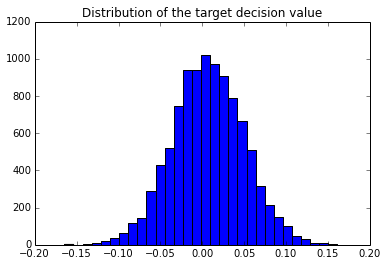

In [291]:
plt.title("Distribution of the target decision value")
_ = plt.hist(y_decision, bins=30)

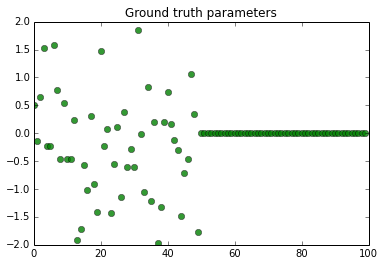

In [292]:
plt.plot(w_true, 'o', color='g', alpha=0.8)
_ = plt.title("Ground truth parameters")

In [293]:
print(intercept_true)

0.00766424730298


In [294]:
def predict(w, X, intercept=0):
    return np.where(np.dot(X, w) + intercept > 0, 1, -1)

Best performance possible (1 - noise level):

In [295]:
np.mean(predict(w_true, X, intercept=intercept_true) == y)

0.99460000000000004

In [296]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

CPU times: user 242 ms, sys: 832 Âµs, total: 243 ms
Wall time: 244 ms


0.96599999999999997

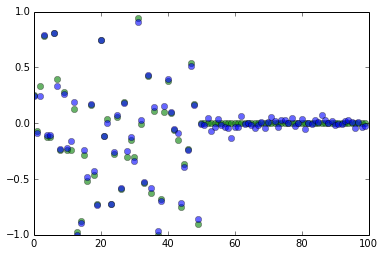

In [317]:
from sklearn.linear_model import PassiveAggressiveClassifier

%time clf = PassiveAggressiveClassifier(C=1e6, n_iter=100).fit(X_train, y_train)

plt.plot(w_true / np.abs(w_true).max(), 'o', color='g', alpha=0.6, label='true')
coef_max = np.abs(clf.coef_.ravel()).max()
plt.plot(clf.coef_.ravel() / coef_max, 'o', color='b', alpha=0.6, label='estimate')

clf.score(X_test, y_test)

CPU times: user 2.05 s, sys: 3.73 ms, total: 2.05 s
Wall time: 2.05 s


0.98119999999999996

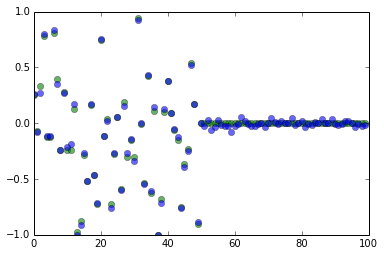

In [301]:
from sklearn.linear_model import SGDClassifier

%time clf = SGDClassifier(loss='log', penalty='l1', alpha=1e-6, n_iter=300).fit(X_train, y_train)

plt.plot(w_true / np.abs(w_true).max(), 'o', color='g', alpha=0.6, label='true')
coef_max = np.abs(clf.coef_.ravel()).max()
plt.plot(clf.coef_.ravel() / coef_max, 'o', color='b', alpha=0.6, label='estimate')

clf.score(X_test, y_test)

Average SGD for penalized logistic regression with 1/t^a with a in [0.5, 0.75]. To make is simpler we make epoch-sized macro-iterations and thus memorize the coef only at those points. A sample level, online averaging scheme (potentially exponentially weighted) would be more correct and actually improve upon the SGD model which is the case here:

Intercept: 0.00420728074987
sgd_train: 0.9945
sgd_test: 0.9896
asgd_train: 0.9947
asgd_test: 0.9900


(0.9, 1)

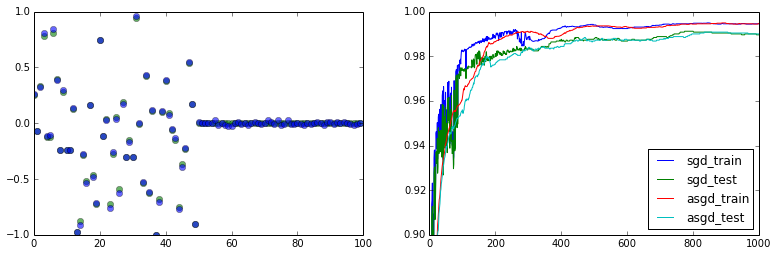

In [314]:
from collections import defaultdict

clf = SGDClassifier(loss='log', penalty='l1', learning_rate='invscaling',
                    power_t=0.6, eta0=1e5, alpha=1e-6)
n_iter = 1000
average_history = 100
weights = []
intercepts = []
scores = defaultdict(list)
for i in range(n_iter):
    clf.partial_fit(X_train, y_train, classes=[-1, 1])
    weights.append(clf.coef_.ravel().copy())
    intercepts.append(clf.intercept_[0])
    mean_coef = np.mean(weights[-average_history:], axis=0)
    mean_intercept = np.mean(intercepts[-average_history:], axis=0)
    
    scores['sgd_test'].append(clf.score(X_test, y_test))
    scores['sgd_train'].append(clf.score(X_train, y_train))
    
    # XXX: clf might have a non-zero bias...
    y_test_pred = predict(mean_coef, X_test, intercept=mean_intercept)
    scores['asgd_test'].append(np.mean(y_test_pred == y_test))
    y_train_pred = predict(mean_coef, X_train, intercept=mean_intercept)
    scores['asgd_train'].append(np.mean(y_train_pred == y_train))

plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.plot(w_true / np.abs(w_true).max(), 'o', color='g', alpha=0.6, label='true')
coef_max = np.abs(mean_coef).max()
plt.plot(mean_coef / coef_max, 'o', color='b', alpha=0.6, label='estimate')
print("Intercept: {}".format(clf.intercept_[0] / coef_max))

plt.subplot(122)
for name, values in sorted(scores.items(), reverse=True):
    plt.plot(values, label=name)
    print("{}: {:.4f}".format(name, values[-1]))
_ = plt.legend(loc='best')
plt.ylim(0.90, 1)

CPU times: user 3.13 s, sys: 11.2 ms, total: 3.14 s
Wall time: 3.15 s
Log Reg test: 0.9936
Intercept: 0.00399473383487


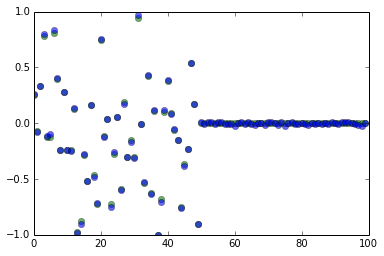

In [303]:
from sklearn.linear_model import LogisticRegression

%time lr = LogisticRegression(C=1e6, penalty='l1').fit(X_train, y_train)

plt.plot(w_true / np.abs(w_true).max(), 'o', color='g', alpha=0.6, label='true')
coef_max = np.abs(lr.coef_.ravel()).max()
plt.plot(lr.coef_.ravel() / coef_max, 'o', color='b', alpha=0.6, label='estimate')

print("Log Reg test: {:.4f}".format(lr.score(X_test, y_test)))
print("Intercept: {}".format(lr.intercept_[0] / coef_max))

CPU times: user 1.65 s, sys: 4.66 ms, total: 1.66 s
Wall time: 1.66 s
Intercept: 0.00550718282395
SVM test: 0.9700


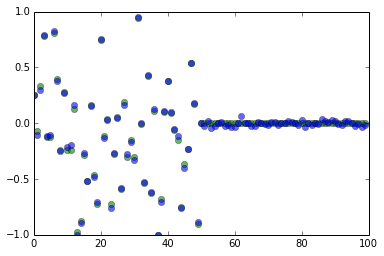

In [313]:
from sklearn.svm import LinearSVC

%time svc = LinearSVC(C=1e6).fit(X_train, y_train)

plt.plot(w_true / np.abs(w_true).max(), 'o', color='g', alpha=0.6, label='true')
coef_max = np.abs(svc.coef_.ravel()).max()
plt.plot(svc.coef_.ravel() / coef_max, 'o', color='b', alpha=0.6, label='estimate')

print("Intercept: {}".format(svc.intercept_[0] / coef_max))
print("SVM test: {:.4f}".format(svc.score(X_test, y_test)))